In [183]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [184]:
# Defining Activation Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

"""
def derivative_ReLU(x):
    return (x > 0).astype(float)

x = np.array([-2, -1, 0, 1, 2])
derivative_ReLU(x)
                            output -> array([0., 0., 0., 1., 1.])    
as you see it is acting like derivative of relu function so i use it
"""

def derivative_ReLU(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [185]:
EPSILON = 1e-13 # we will use it for case that not be infinite my logarithm.
# Defining Loss Functions
def mean_squared_error(y_actual, y_predicted):
    return np.mean((y_actual - y_predicted) ** 2) # MSE for Regressions

def binary_cross_entropy(y_actual, y_predicted):
    return -np.mean(y_actual * np.log(y_predicted + EPSILON) + (1 - y_actual) * np.log(1 - y_predicted + EPSILON))

def categorical_cross_entropy(y_actual, y_predicted):
    return -np.mean(np.sum(y_actual * np.log(y_predicted + EPSILON), axis=1))

In [186]:
# Defining NN Class
"""
    strategy: 
    - we use activation name for hidden layers of neural network
    - we use output_activation name for output layer of NN
    - For regression tasks, a linear activation (or no activation) is used because the output can take any real value
    - For binary classification we use sigmoid function cause we wanna be 0-1
    - For multi classification we use softmax function cause be probability distribution across multi classes
"""
class Network:
    def __init__(self, layers, task="regression", learning_rate=0.01):
        self.layers = layers
        self.learning_rate = learning_rate
        self.task = task

        # Initializing Weights and Biases
        self.weights = []
        self.biases = []
        
        for i in range(len(layers) -1):
            weight = np.random.rand(layers[i], layers[i+1]) * 0.01 # making sure that weights be small to not affect learning
            bias = np.zeros((1, layers[i+1]))
            self.weights.append(weight)
            self.biases.append(bias)
            
            # Setting Activation Function based on Task type (I referenced the loss and activation functions not call it immediately notice this)
            if task == "regression":
                self.activation = ReLU
                self.output_activation = ReLU # linear activation for regression
                self.cost_function = mean_squared_error

            elif task == "binary_classification":
                self.activation = ReLU
                self.output_activation = sigmoid
                self.cost_function = binary_cross_entropy

            elif task == "multi_classification":
                self.activation = ReLU
                self.output_activation = softmax
                self.cost_function = categorical_cross_entropy
            
            else:
                raise ValueError("Unsupported Task Type :)")

    # Forward Propagation
    def forward_pass(self, x):
        self.activations = [x]
        for i in range(len(self.weights)):
            z = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            a_next = self.activation(z) if i < len(self.weights) -1 else self.output_activation(z) # cause our strategy produce this. i < len(self.weights) -1 cause activation is for hidden layers and output_activation is for output layers. notice that here we are calling the function that referenced in separating tasks.
            self.activations.append(a_next)
        return self.activations[-1] # final value in our list is predicted value

    # Back Propagation
    def backward_pass(self, x, y):
        m = len(y)

        # Calculating delta based on the task type
        if self.task == "regression":
            delta = (self.activations[-1] - y)
        else:
            delta = (self.activations[-1] - y) # for clarity or future changing i separate them but now same method for binary and multi-class classifications i used.

        for i in reversed(range(len(self.weights))):
            dw = np.dot(self.activations[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m

            # Updating weights and biases
            self.weights[i] -= self.learning_rate * dw
            self.biases[i] -= self.learning_rate * db

            # We do not apply the derivative of output layer because in mathematic of that we know the output layer used specific cost_function or specific loss, actually we send the output of output_activation to loss_function.
            if i > 0: # applying only for hidden layers. (at first my output layer is done from above code i wrote now we are sure this below is for hidden layers. notice that our activation functions all are ReLU.)
                delta = np.dot(delta, self.weights[i].T) * derivative_ReLU(self.activations[i]) # i created the derivative of relu for using here.

    def train(self, x, y, epochs=10000):
        losses = []
        for epoch in range(epochs):
            output = self.forward_pass(x)
            loss = self.cost_function(y, output)
            losses.append(loss)
            self.backward_pass(x,y)
            if epoch % 1000 == 0:  # We can Print loss every 1000 epochs for monitoring progress
                print(f'Epoch {epoch}: Loss {loss}')
        return losses

Epoch 0: Loss 0.6931439861389894
Epoch 1000: Loss 0.6874733115354041
Epoch 2000: Loss 0.6874321042651793
Epoch 3000: Loss 0.6874292147088398
Epoch 4000: Loss 0.6874254831584452
Epoch 5000: Loss 0.6874198448761838
Epoch 6000: Loss 0.6874107681920607
Epoch 7000: Loss 0.687395052866103
Epoch 8000: Loss 0.6873650179026015
Epoch 9000: Loss 0.6872996610800713


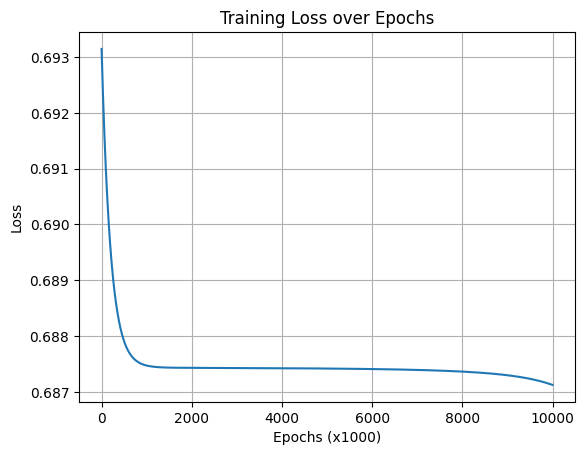

In [189]:
# Train The NN with Pandas example
data = pd.read_csv("heart.csv")

# Preprocessing
# Convert categorical variables to numerical
data["Sex"] = data["Sex"].map({"M": 1, "F": 0})
data["ChestPainType"] = data["ChestPainType"].map({"ATA": 0, "NAP": 1, "ASY": 2, "TA": 3}) # with data["ChestPainType"].unique() i recognize what is uniquely contained.
data["RestingECG"] = data["RestingECG"].map({"Normal": 0, "ST": 1, "LVH": 2})
data["ExerciseAngina"] = data["ExerciseAngina"].map({"N": 0, "Y": 1})
data["ST_Slope"] = data["ST_Slope"].map({"Up": 0, "Flat": 1, "Down": 2})

# Features and Labels separating
X = data.drop("HeartDisease", axis=1).values
Y = data["HeartDisease"].values.reshape(-1, 1) # make it from 1D-dimensional to 2D-dimensional

# Now our data convert to numerical we normalize that
# Normalize features (Actually we Standard it)
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Now Define and train with out Network class NN
layers = [X.shape[1], 10, 5, 1] # Input layer, two hidden layers, output layer (number of neurons of hidden and output layers is on my hand i choose them).
nn = Network(layers=layers, learning_rate=0.01, task="binary_classification")
losses = nn.train(X, Y, epochs=10000)

# Plotting the loss over epochs
plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs (x1000)")
plt.ylabel("Loss")
plt.grid()
plt.show()